# Flight Arrival and Departure Data Exploration
## by Lucas Amaro de Oliveira

## Investigation Overview

In this investigation, I am interested in finding out which characteristics have the most influence on flight delay and cancellation. The main focus is the time parameters: Month, day of the week, time of the day; the carrier; The aircraft tail number; and the flight distance.

## Dataset Overview

The data consists of flight arrival and departure details for all commercial flights within the USA in 2007.
There are 7453215 flights in the dataset with 29 features.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

%matplotlib inline

sns.set_theme(style='ticks')

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
flights_2007_df = pd.read_csv('./Data/2007.csv')
carriers_df = pd.read_csv('./Data/carriers.csv')

index = carriers_df.query('Code == "US"').index.values
carriers_df.loc[index,'Description'] =  'US Airways Inc.*'

flights_2007_df = flights_2007_df.merge(carriers_df, left_on='UniqueCarrier', right_on='Code')

flights_2007_df.drop(columns={'AirTime', 'ArrDelay', 'DepDelay', 'Origin', 'Dest', 'TaxiIn', 'TaxiOut'}, inplace=True)

flights_2007_df.rename(columns={'Year':'year',
                                'Month':'month',
                                'DayofMonth':'day',
                                'DayOfWeek':'day_of_week',
                                'DepTime':'actual_departure_time',
                                'CRSDepTime':'scheduled_departure_time',
                                'ArrTime':'actual_arrival_time',
                                'CRSArrTime':'scheduled_arrival_time',
                                'UniqueCarrier':'carrier',
                                'FlightNum':'flight_number',
                                'TailNum':'tail_number',
                                'ActualElapsedTime':'actual_elapsed_time',
                                'CRSElapsedTime':'scheduled_elapsed_time',
                                'AirTime':'air_time',
                                'ArrDelay':'arrival_delay',
                                'DepDelay':'departure_delay',
                                'Origin':'origin',
                                'Dest':'destination',
                                'Distance':'distance',
                                'TaxiIn':'taxi_in_time',
                                'TaxiOut':'taxi_out_time',
                                'Cancelled':'cancelled',
                                'CancellationCode':'cancellation_code',
                                'Diverted':'diverted',
                                'CarrierDelay':'carrier_delay',
                                'WeatherDelay':'weather_delay',
                                'NASDelay':'NAS_delay',
                                'SecurityDelay':'security_delay',
                                'LateAircraftDelay':'late_aircraft_delay',
                                'Description': 'carrier_description'
                                }, inplace=True)

flights_2007_df['date'] = pd.to_datetime(flights_2007_df[['year','month','day']])
flights_2007_df.drop(columns=['year','month','day','day_of_week'],inplace=True)

flights_2007_df.date.head(3)

def to_4_digits(x):
    if x==x:
        x='{:04d}'.format(x)
        return x
flights_2007_df.scheduled_departure_time = pd.to_datetime(flights_2007_df.scheduled_departure_time.apply(to_4_digits), format ='%H%M', errors='coerce')

flights_2007_df.replace(to_replace={'cancellation_code':['A','B','C','D']},value={'cancellation_code':['carrier', 'weather', 'NAS', 'security']},inplace=True)

flights_2007_df['total_delay'] = flights_2007_df.carrier_delay + flights_2007_df.weather_delay + flights_2007_df.NAS_delay + flights_2007_df.security_delay + flights_2007_df.late_aircraft_delay


hour_edges = [0,3,6,9,12,15,18,21,24]
hour_lebals = ['0h-3h','3h-6h','6h-9h','9h-12h','12h-15h','15h-18h','18h-21h','21h-24h']
flights_2007_df['hour_range'] = pd.cut(flights_2007_df.scheduled_departure_time.dt.hour,hour_edges,labels=hour_lebals, include_lowest=True)

In [3]:
#fuction from https://stackoverflow.com/a/56780852  and https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/

def show_values_on_bars(axs, h_v="v", ha='center', va='center', xytext=(0, 0), color='black', formater='{:.2f}', unit='u'):
    def _show_on_single_plot(ax):  
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                if unit=='u':
                    value = formater.format(p.get_height())
                elif unit=='k':
                    value = formater.format(p.get_height()/10**3)
                elif unit=='M':
                    value = formater.format(p.get_height()/10**6)
                
                ax.annotate(value, 
                            (_x, _y), ha=ha, va=va, xytext=xytext, color=color, textcoords='offset points')
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() # + float(space)
                _y = p.get_y() + p.get_height()
                if unit=='u':
                    value = formater.format(p.get_width())
                elif unit=='k':
                    value = formater.format(p.get_width()/10**3)
                elif unit=='M':
                    value = formater.format(p.get_width()/10**6)
                ax.annotate(value, 
                            (_x, _y), ha=ha, va=va, xytext=xytext, color=color, textcoords='offset points')
                
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


## Distribution of flights over the months in 2007

The flights are very evenly distributed over the months! Much more than I expected.

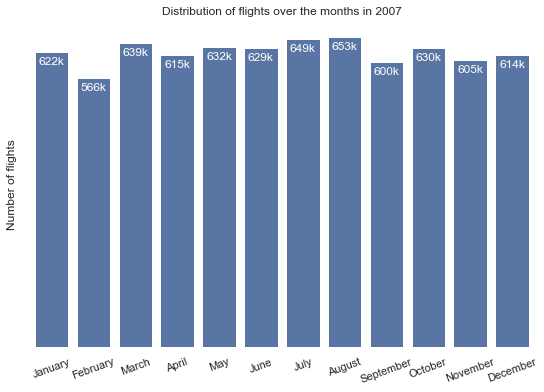

In [4]:
with sns.axes_style('white'):
    plt.figure(figsize=(9,6))
    color = sns.color_palette()[0]
    g = sns.countplot(x=flights_2007_df.date.dt.month, color=color);
    
    plt.title('Distribution of flights over the months in 2007');

    g.set(xticklabels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ])
    plt.xticks(rotation=20);
    plt.xlabel('');
    g.set(yticklabels='')
    plt.ylabel('Number of flights')
    
    sns.despine(left=True, bottom=True)
    show_values_on_bars(g, ha='center', va='top', xytext=(0, -5), color='white', formater='{:.0f}k', unit='k')

## Proportion of delayed or cancelled flights by month

Although the number of flights is evenly distributed over the month, the proportion of delayed or cancelled flights are not. December has the highest proportion of delayed or cancelled flights, probably due to holidays. The summer months (June to August) also have a high proportion. The proportion in December is almost twice as in September.

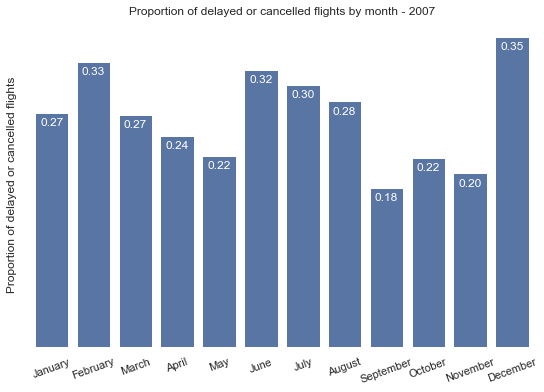

In [10]:
delay_by_month = flights_2007_df.query('total_delay >0 or cancelled==1').groupby(pd.Grouper(key='date', freq='M'))['carrier'].count() / flights_2007_df.groupby(pd.Grouper(key='date', freq='M'))['carrier'].count()
with sns.axes_style('white'):
    plt.figure(figsize=(9,6))
    color = sns.color_palette()[0]
    g = sns.barplot(x=delay_by_month.index, y=delay_by_month.values, color=color);
    g.set(xticklabels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December' ])
    plt.xticks(rotation=20);
    plt.xlabel('');
    g.set(yticklabels='')
    plt.ylabel('Proportion of delayed or cancelled flights')
          
    plt.title('Proportion of delayed or cancelled flights by month - 2007');
    
    sns.despine(left=True, bottom=True)
    show_values_on_bars(g, ha='center', va='top', xytext=(0, -5), color='white')


## Proportion of delayed or cancelled flights by the time of the day and day of the week

From 3:00 to 9:00 is the best time to fly since this period presents no more than 20% of delayed or cancelled flights. Next is between 9:00 and 12:00 and on Saturday with 26% or less cancelled or delayed flights. On Thursday and Friday between 18:00 and 21:00 we have the impressive value of 41% of cancellations or delays. It is definitely not a good time if we want to fly without these inconveniences.

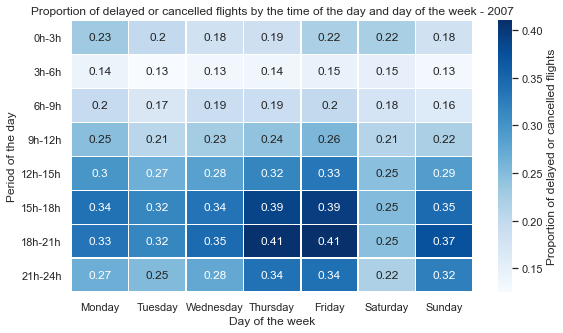

In [6]:
df=pd.DataFrame()
for day in np.arange(7):
    df1 = flights_2007_df[flights_2007_df['date'].dt.weekday==day]
    df2 = df1.query('total_delay >0 or cancelled==1')
    delay_by_hour_range = df2.groupby('hour_range')['hour_range'].count() / df1.groupby('hour_range')['hour_range'].count()
    df[day] = delay_by_hour_range

with sns.axes_style('white'):
    plt.figure(figsize=(9,5))
    g = sns.heatmap(df, annot=True, linewidth=.5, cmap="Blues", cbar_kws={'label': 'Proportion of delayed or cancelled flights'});
    g.set(xticklabels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.xlabel('Day of the week')
    plt.ylabel('Period of the day')
    plt.title('Proportion of delayed or cancelled flights by the time of the day and day of the week - 2007');

## The proportion of delayed or cancelled flights by carrier

The proportion of delayed or cancelled flights change a lot according to the carrier. Atlantic Southeast Airlines presented 5 times more of these problems than Hawaiian Airlines.

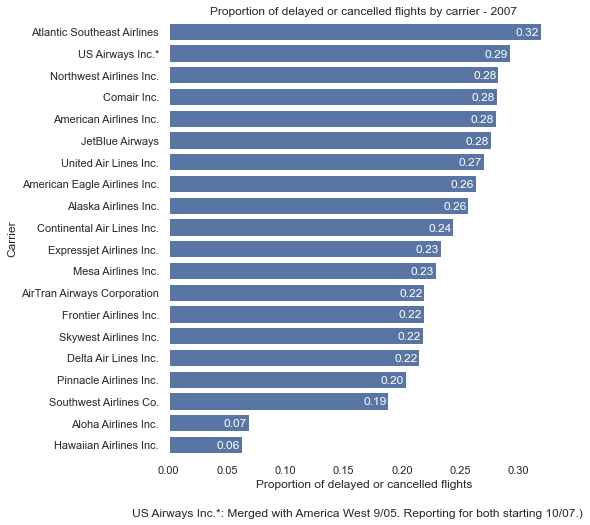

In [11]:
delay_by_carrier = flights_2007_df.query('total_delay >0 or cancellation_code=="A"').groupby('carrier_description')['carrier_description'].count() / flights_2007_df.groupby('carrier_description')['carrier_description'].count()
delay_by_carrier = delay_by_carrier.sort_values(ascending=False)

with sns.axes_style('white'):
    plt.figure(figsize=(7,8))
    color = sns.color_palette()[0]
    g = sns.barplot(y=delay_by_carrier.index, x=delay_by_carrier.values, color=color);
    sns.despine(left=True, bottom=True);
    plt.ylabel('Carrier')
    plt.xlabel('Proportion of delayed or cancelled flights')
    plt.title('Proportion of delayed or cancelled flights by carrier - 2007')
    show_values_on_bars(g, h_v='h', ha='right', va='bottom', xytext=(-2, 3), color='white')
    plt.figtext(0.5, 0.02, 'US Airways Inc.*: Merged with America West 9/05. Reporting for both starting 10/07.)', ha="center")
    

## Proportion of delayed or celled flights and total number of flights for each aicraft

This correlation was not as I expected! The aircraft with the most number of flights, in fact, presented the lower proportion of delays or cancellation. I was expecting that the busiest ones have the most delays or cancellation.

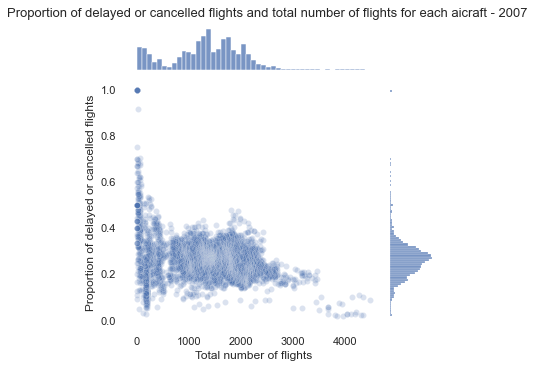

In [14]:
tails_df = pd.DataFrame(flights_2007_df.tail_number.value_counts())
tails_df.rename(columns={'tail_number':'total_flights'}, inplace=True)

tails_df.drop(['0','000000'], axis=0, inplace=True)

delayed_flights_by_tail = flights_2007_df.query('total_delay >0 or cancelled==1').groupby('tail_number')['tail_number'].count() / flights_2007_df.groupby('tail_number')['tail_number'].count()
tails_df = tails_df.join(delayed_flights_by_tail)
tails_df.rename(columns={'tail_number':'delayed_flights'}, inplace=True)

with sns.axes_style('white'):
    g = sns.JointGrid(height=5, ratio=5);
    sns.scatterplot(data=tails_df, x='total_flights', y='delayed_flights', alpha=.2, ax=g.ax_joint);
    g.ax_joint.set(xlabel = 'Total number of flights');
    g.ax_joint.set(ylabel = 'Proportion of delayed or cancelled flights');

    sns.histplot(data=tails_df, x='total_flights', ax=g.ax_marg_x);
    sns.histplot(data=tails_df, y='delayed_flights', ax=g.ax_marg_y);
    g.fig.subplots_adjust(top=0.925);

    plt.suptitle('Proportion of delayed or cancelled flights and total number of flights for each aicraft - 2007', fontsize=13);
    sns.despine(left=True, bottom=True)

## Proportion of delayed or cancelled flights by fligth distance

The proportion of delayed or cancelled flights were evenly distributed. With shorter flights presenting slighted fewer delays or cancellations, proportionally.

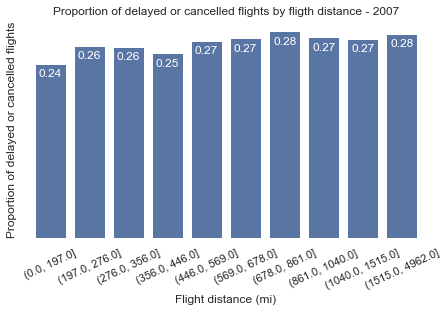

In [13]:
distance_edges = [flights_2007_df.distance.quantile(x) for x in np.arange(0,1.001,0.1)]
distance_edges[0] = 0
flights_2007_df['distance_label'] = pd.cut(flights_2007_df.distance, distance_edges)

delay_by_distance_label = flights_2007_df.query('total_delay >0 or cancelled==1').groupby('distance_label')['distance_label'].count() / flights_2007_df.groupby('distance_label')['distance_label'].count()
delay_by_distance_label = delay_by_distance_label.sort_values(ascending=False)

with sns.axes_style('white'):
    plt.figure(figsize=(7,4))
    color = sns.color_palette()[0]
    g = sns.barplot(x=delay_by_distance_label.index, y=delay_by_distance_label.values, color=color);
    plt.xticks(rotation=25);
    g.set(yticklabels='')
    
    sns.despine(left=True, bottom=True)
    show_values_on_bars(g, ha='center', va='top', xytext=(0, -5), color='white')
    plt.xlabel('Flight distance (mi)')
    plt.ylabel('Proportion of delayed or cancelled flights')
    plt.title('Proportion of delayed or cancelled flights by fligth distance - 2007')

## Conclusion.

To avoid troubles during our flight experiences like delays or cancellations, we can:
- Fly during spring or autumn, if possible;
- Fly in mornings or Saturdays. Preferably, early mornings.
- Choose one of the carries with lower proportion or delays or cancellations previously presented.

The fight distance didn't affect as much the proportion of trouble. Shorter resented slighted fewer delays or cancellations, proportionally.

`jupyter nbconvert flight_exploration.ipynb --to slides --no-input`